https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

In [4]:
PATH = 'data/nyc-taxi/'

The entire dataset has about 55,423,857 rows

In [5]:
proc_df??

# Load clean dataframe

In [5]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt4')

Wall time: 8.5 s


In [6]:
all_val_index_df = pd.read_csv('tmp/validation_list1.csv', header=None)

# Split Training-Validation Data

In [7]:
unique_val_list = list(set(all_val_index_df[0].tolist())) # get unique values

In [8]:
len(all_val_index_df), len(unique_val_list),

(9914, 9154)

In [9]:
n_valid = len(unique_val_list)
n_valid

9154

In [10]:
val_df = train_df.iloc[unique_val_list].copy()

In [11]:
%%time
pruned_train_df = train_df.drop(unique_val_list, axis='rows')

Wall time: 9.45 s


In [12]:
assert len(pruned_train_df) + len(val_df) == len(train_df)

In [13]:
pruned_train_df.shape, val_df.shape

((54051828, 17), (9154, 17))

In [14]:
del train_df

In [15]:
%%time
# X_trn, y_trn, _ = proc_df(pruned_train_df,'fare_amount') # get all

subsample = 30_000_000
X_trn, y_trn, nas = proc_df(pruned_train_df, 'fare_amount', subset=subsample)

X_val, y_val, _ = proc_df(val_df,'fare_amount')

Wall time: 55.4 s


In [16]:
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

((30000000, 16), (9154, 16), (30000000,), (9154,))

# Train

## Helper functions

In [17]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):  
    
    # in scikit-learn, random forest regressor,score is the r-squared value
    trn_scr = m.score(X_trn, y_trn)
    val_scr = m.score(X_val, y_val)
    
    # RMSE is what we are more interested in
    trn_rmse = rmse(m.predict(X_trn), y_trn)
    val_rmse = rmse(m.predict(X_val), y_val)
    if hasattr(m, 'oob_score_'): oob_scr = m.oob_score_
        
    res = f"Training-Score:   {trn_scr:.5f}\tTraining-rmse:   {trn_rmse:.5f}\n"
    res += f"Validation-score: {val_scr:.5f}\tValidation-rmse: {val_rmse:.5f}"   
    if hasattr(m, 'oob_score_'): res += f"\nOOB-score:\t  {oob_scr:.5f}"
        
    print(res)
    
def print_val_score(m):  
    val_scr = m.score(X_val, y_val)
    val_rmse = rmse(m.predict(X_val), y_val)
    res = f"Validation-score: {val_scr:.5f}\tValidation-rmse: {val_rmse:.5f}"        
    print(res)

## Fit on training data

In [18]:
m = RandomForestRegressor(n_estimators=120, min_samples_leaf=5, max_features=0.5, n_jobs=-1)

In [ ]:
%time m.fit(X_trn, y_trn)

In [ ]:
%time print_score(m)

# Predict on test data

In [21]:
# We need 'key' for the test submission file
test_df_raw = pd.read_csv(f'{PATH}test.csv', usecols=['key'])

In [22]:
test_df = pd.read_feather('tmp/taxi-test-chkpt4')

In [23]:
test_y_predictions = m.predict(test_df)

# Submit

In [24]:
from datetime import datetime as dt

In [25]:
outdir = 'submissions'
os.makedirs(outdir, exist_ok=True)
    
cur_dt = dt.now().strftime("%Y%m%d_%H%M%S")
desc = 'v05_RF_' # description of submission for reference
subm_fn =  desc + cur_dt + '.csv'
subm_path = f'{outdir}/{subm_fn}'

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df_raw.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv(subm_path, index = False)

subm_path

'submissions/v05_RF_20180729_134145.csv'

Kaggle Score:

# Save model

In [26]:
del pruned_train_df

In [27]:
model_fn_save = 'models/v05_RF_20180729_121842.pkl'

In [28]:
%time pickle.dump(m, open(model_fn_save, 'wb'))

Wall time: 3min 26s


# Load Model

In [ ]:
model_fn_open = 'models/<>'

In [ ]:
%time m = pickle.load(open(model_fn_open, 'rb'))

# Feature Importance

In [251]:
fi = rf_feat_importance(m, X_trn); 
fi

,cols,imp
7,simple_distance,0.496604
5,abs_diff_longitude,0.206173
6,abs_diff_latitude,0.098371
2,dropoff_longitude,0.047676
0,pickup_longitude,0.043354
8,pickup_datetimeYear,0.025300
3,dropoff_latitude,0.022418
1,pickup_latitude,0.017140
14,pickup_datetimeHour,0.010691
13,pickup_datetimeDayofyear,0.007575


In [252]:
pd.DataFrame({'cols':X_trn.columns, 'imp':m.feature_importances_}).sort_values(by='imp', ascending=False)

,cols,imp
7,simple_distance,0.496604
5,abs_diff_longitude,0.206173
6,abs_diff_latitude,0.098371
2,dropoff_longitude,0.047676
0,pickup_longitude,0.043354
8,pickup_datetimeYear,0.025300
3,dropoff_latitude,0.022418
1,pickup_latitude,0.017140
14,pickup_datetimeHour,0.010691
13,pickup_datetimeDayofyear,0.007575


In [253]:
def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

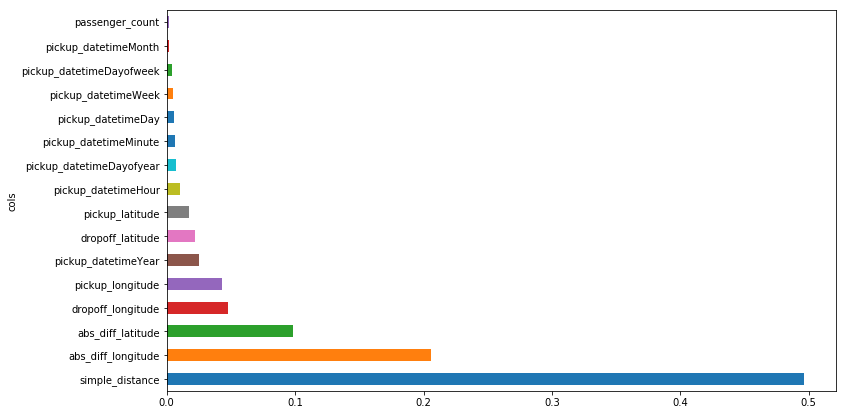

In [254]:
plot_fi(fi)